In [1]:
import os
os.chdir("../../../../")
import egg
import torch
from collections import Counter
from typing import List, Tuple, Dict, Optional
from torch import nn, Tensor
from torchvision.ops import box_convert
from matplotlib.patches import Rectangle
import matplotlib.patches as mpatches
from matplotlib import pyplot as plt

In [5]:
def resize_boxes(boxes: Tensor, original_size: List[int], new_size: List[int]) -> Tensor:
    ratios = [
        torch.tensor(s, dtype=torch.float32, device=boxes.device)
        / torch.tensor(s_orig, dtype=torch.float32, device=boxes.device)
        for s, s_orig in zip(new_size, original_size)
    ]
    ratio_height, ratio_width = ratios
    xmin, ymin, xmax, ymax = boxes.unbind(1)

    xmin = xmin * ratio_width
    xmax = xmax * ratio_width
    ymin = ymin * ratio_height
    ymax = ymax * ratio_height
    return torch.stack((xmin, ymin, xmax, ymax), dim=1)

In [4]:
DA_model = "/Volumes/TOSHIBA/PhD/EmeComm/interactions/da_model.interaction"
TO_model = "/Volumes/TOSHIBA/PhD/EmeComm/interactions/to_model.interaction"

In [6]:
inter_DA = torch.load(DA_model)
inter_TO = torch.load(TO_model)

In [8]:
msg_DA = inter_DA.message
n_batches_DA, bsz_DA, max_objs_DA = inter_DA.aux_input["mask"].shape
msg_DA = torch.argmax(msg_DA.view(n_batches_DA, bsz_DA, max_objs_DA, 2, -1), dim=-1)

msg_TO = inter_TO.message
n_batches_TO, bsz_TO, max_objs_TO = inter_TO.aux_input["mask"].shape
msg_TO = torch.argmax(msg_TO.view(n_batches_TO, bsz_TO, max_objs_TO, 2, -1), dim=-1)

In [10]:
msg_TO.shape # 39 batches x 128 immagini a batch x 9 oggetti a immagine x 2 messaggi a oggetto

torch.Size([39, 128, 9, 2])

### Check which symbols have been used

In [288]:
msg_pairs = []

for batch_id, batch in enumerate(inter_DA.aux_input['mask']):
        batch_msg = msg_DA[batch_id]
        for mex, batch_elem in list(zip(batch_msg, batch)):
            for obj_mex, obj in list(zip(mex,batch_elem)):
                if obj == True:
                    msg_pairs.append(obj_mex.tolist())

In [289]:
msg_first_sym = []

for batch_id, batch in enumerate(inter_DA.aux_input['mask']):
        batch_msg = msg_DA[batch_id]
        for mex,batch_elem in list(zip(batch_msg, batch)):
            for obj_mex, obj in list(zip(mex,batch_elem)):
                if obj == True:
                    msg_first_sym.append(int(obj_mex[0]))

In [290]:
msg_second_sym = []

for batch_id, batch in enumerate(inter_DA.aux_input['mask']):
        batch_msg = msg_DA[batch_id]
        for mex,batch_elem in list(zip(batch_msg, batch)):
            for obj_mex, obj in list(zip(mex,batch_elem)):
                if obj == True:
                    msg_second_sym.append(int(obj_mex[1]))

In [292]:
Counter(tuple(item) for item in msg_pairs).most_common()

[((3675, 3665), 1082),
 ((2812, 3665), 965),
 ((1884, 3665), 956),
 ((591, 3665), 939),
 ((1927, 3668), 909),
 ((3675, 1892), 881),
 ((1884, 1892), 853),
 ((208, 3668), 850),
 ((3198, 3665), 772),
 ((3628, 3668), 771),
 ((3899, 3665), 766),
 ((3628, 3665), 726),
 ((591, 1892), 693),
 ((3764, 3665), 689),
 ((3628, 1892), 661),
 ((208, 1892), 647),
 ((2529, 1892), 644),
 ((1874, 1892), 627),
 ((3764, 1892), 623),
 ((591, 3668), 622),
 ((1927, 3665), 590),
 ((910, 1892), 582),
 ((1095, 3668), 576),
 ((1874, 3276), 570),
 ((3675, 3668), 559),
 ((2529, 3668), 554),
 ((2812, 1892), 544),
 ((1927, 1892), 534),
 ((910, 3665), 528),
 ((3198, 1892), 524),
 ((208, 3665), 491),
 ((3899, 3668), 484),
 ((1874, 3665), 462),
 ((2529, 3665), 458),
 ((1884, 3668), 450),
 ((3198, 3668), 436),
 ((2812, 3668), 435),
 ((3899, 1892), 426),
 ((1884, 3276), 414),
 ((188, 3668), 410),
 ((2529, 3276), 394),
 ((3483, 3665), 393),
 ((3675, 3276), 383),
 ((3628, 3276), 369),
 ((208, 3276), 365),
 ((1095, 3665), 365

In [293]:
Counter(msg_first_sym).most_common()

[(3675, 3324),
 (591, 3011),
 (1927, 3011),
 (208, 2999),
 (3628, 2968),
 (1884, 2965),
 (2529, 2427),
 (3899, 2375),
 (2812, 2335),
 (3198, 2309),
 (3764, 2113),
 (1874, 2046),
 (1095, 1990),
 (910, 1803),
 (188, 1121),
 (3483, 682),
 (3020, 320),
 (2833, 8)]

In [294]:
Counter(msg_second_sym).most_common()

[(3665, 10439),
 (1892, 8924),
 (3668, 7921),
 (3276, 4960),
 (31, 1480),
 (3771, 1142),
 (3068, 1095),
 (3126, 1030),
 (1257, 471),
 (1988, 345)]

In [12]:
rcv_out_DA = inter_DA.receiver_output
rcv_out_DA = torch.argmax(rcv_out_DA.view(n_batches_DA, bsz_DA, max_objs_DA, -1), dim=-1)

rcv_out_TO = inter_TO.receiver_output
rcv_out_TO = torch.argmax(rcv_out_TO.view(n_batches_TO, bsz_TO, max_objs_TO, -1), dim=-1)

In [131]:
# define patches for our legend

red_patch = mpatches.Patch(color='red', label='send target')
aqua_patch = mpatches.Patch(color='aqua', label='rec target DA')
green_patch = mpatches.Patch(color='limegreen', label='rec target TO')
fuchsia_patch = mpatches.Patch(color='fuchsia', label='attended DA')
blue_patch = mpatches.Patch(color='blue', label='all the rest')

In [310]:
# define bboxes appearance

def image_target_box(image, tar):
    plt.figure(figsize=(7,7))
    plt.legend(handles=[red_patch, aqua_patch, green_patch, fuchsia_patch, blue_patch], fontsize=10)
    plt.imshow(image)
    plt.gca().add_patch(Rectangle((tar[0], tar[1]), tar[2], tar[3], edgecolor='red', facecolor='none', lw = 5))

def aqua_box(obj):
    plt.gca().add_patch(Rectangle((obj[0]-0.3, obj[1]-0.3), obj[2]-0.6, obj[3]-0.6, edgecolor='aqua', facecolor='none', lw = 4))
    
def green_box(obj):
    plt.gca().add_patch(Rectangle((obj[0]-1, obj[1]-1), obj[2]+2.5, obj[3]+2.5, edgecolor='limegreen', facecolor='none', lw = 4))

def fuchsia_box(obj):
    plt.gca().add_patch(Rectangle((obj[0]-0.6, obj[1]-0.6), obj[2]+1.6, obj[3]+1.6, edgecolor='fuchsia', facecolor='none', lw = 4))
    
def blue_box(obj):
    plt.gca().add_patch(Rectangle((obj[0], obj[1]), obj[2], obj[3], edgecolor='blue', facecolor='none', lw = 3))

In [298]:
# define rules for bbox colors

def color_rule(transormed_boxes, idx_other_obj, rcv_idx_DA, other_obj, obj, rcv_idx_TO, att_out_DA, idx_obj):
    if idx_other_obj == rcv_idx_DA:
        aqua_box(other_obj)                                       
    if idx_other_obj == rcv_idx_TO:
        green_box(other_obj)                                     
    if idx_other_obj == torch.argmax(att_out_DA):
        fuchsia_box(other_obj)                                
    if idx_obj != idx_other_obj:
        blue_box(other_obj)

In [299]:
# define our assertion rule that we'll use to be sure: 
# when the model guesses, we the output object must be equal to the input object
def assertion_rule(other_obj, obj, idx_other_obj, rcv_idx_model):
    if idx_other_obj == rcv_idx_model:
        assert other_obj.tolist() == obj.tolist(), "Mismatch guess!"

In [300]:
def visual_analysis_2sym(symbol1, symbol2, batch_id, guessed_DA, guessed_TO, num_att_head):

    for this_batch_id, batch in enumerate(msg_DA):
        if this_batch_id == batch_id:
            for idx_img, img, or_size, bboxes in list(zip(range(0,len(inter_DA.aux_input["sender_image"])),
                                            inter_DA.aux_input['sender_image'][this_batch_id],  
                                            inter_DA.aux_input["image_sizes"][this_batch_id],
                                            inter_DA.aux_input['bboxes'][this_batch_id])):
    
                or_w, or_h = or_size.tolist()[0][1], or_size.tolist()[0][2]
                xyxy = box_convert(bboxes, "xywh", "xyxy") 
                t_boxes = resize_boxes(xyxy, (or_w, or_h), (128,128))
                t_xywh = box_convert(t_boxes, "xyxy", "xywh") 
                image = img.permute(1, 2, 0)
                                 
                for idx_obj, mex, bbox, mask, guess_DA, obj, rcv_idx_DA, rcv_idx_TO, att_out_DA, in list(zip(range(0,len(inter_DA.aux_input["bboxes"])),
                                        msg_DA[this_batch_id][idx_img],
                                        inter_DA.aux_input['bboxes'][this_batch_id][idx_img],
                                        inter_DA.aux_input['mask'][this_batch_id][idx_img],
                                        inter_DA.aux_input['guesses'][this_batch_id][idx_img],
                                        t_xywh,
                                        rcv_out_DA[this_batch_id][idx_img],
                                        rcv_out_TO[this_batch_id][idx_img],
                                        inter_DA.aux_input["attn_weights"][this_batch_id][idx_img][num_att_head])): 
                    
                    if mask == True:
                        if guessed_DA == "yes": # IF DA HAS GUESSED
                            if guessed_TO == "yes": # IF TO HAS GUESSED
                                if mex[0] == symbol1 and mex[1] == symbol2 and guess_DA == 1.0 and rcv_idx_TO == idx_obj:
                                    image_target_box(image, obj)
                                    for idx_other_obj, other_obj in list(enumerate(t_xywh)):
                                        color_rule(t_boxes, idx_other_obj, rcv_idx_DA, other_obj, obj, rcv_idx_TO, att_out_DA, idx_obj)     
                                        assertion_rule(other_obj, obj, idx_other_obj, rcv_idx_DA)
                                        assertion_rule(other_obj, obj, idx_other_obj, rcv_idx_TO)
                                        
                            if guessed_TO == "no": # IF TO HAS NOT GUESSED
                                if mex[0] == symbol1 and mex[1] == symbol2 and guess_DA == 1.0 and rcv_idx_TO != idx_obj:
                                    image_target_box(image, obj)
                                    for idx_other_obj, other_obj in list(enumerate(t_xywh)):
                                        color_rule(t_boxes, idx_other_obj, rcv_idx_DA, other_obj, obj, rcv_idx_TO, att_out_DA, idx_obj)     
                                        assertion_rule(other_obj, obj, idx_other_obj, rcv_idx_DA)
                                        
                        elif guessed_DA == "no":
                            if guessed_TO == "yes": # IF TO HAS GUESSED:
                                if mex[0] == symbol1 and mex[1] == symbol2 and guess_DA != 1.0 and rcv_idx_TO == idx_obj:
                                    image_target_box(image, obj)
                                    for idx_other_obj, other_obj in list(enumerate(t_xywh)):                
                                        color_rule(t_boxes, idx_other_obj, rcv_idx_DA, other_obj, obj, rcv_idx_TO, att_out_DA, idx_obj)
                                        assertion_rule(other_obj, obj, idx_other_obj, rcv_idx_TO)
                                        
                            if guessed_TO == "no": # IF TO HAS NOT GUESSED:         
                                if mex[0] == symbol1 and mex[1] == symbol2 and guess_DA != 1.0 and rcv_idx_TO != idx_obj:         
                                    image_target_box(image, obj)
                                    for idx_other_obj, other_obj in list(enumerate(t_xywh)):       
                                        color_rule(t_boxes, idx_other_obj, rcv_idx_DA, other_obj, obj, rcv_idx_TO, att_out_DA, idx_obj)
                                    
                    
                        plt.show()

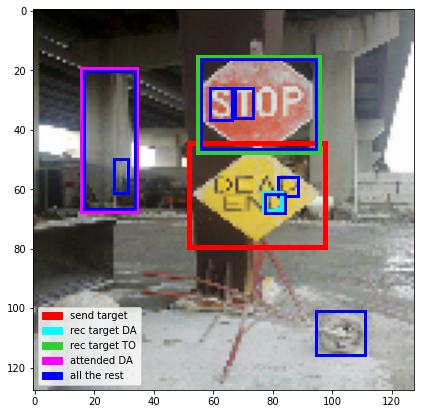

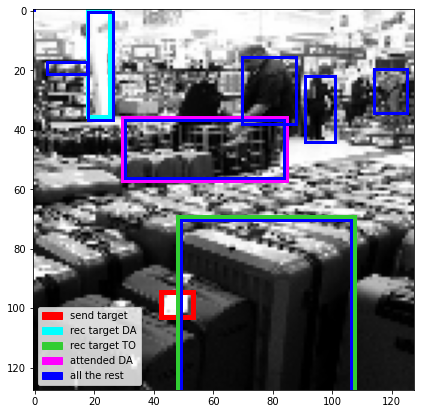

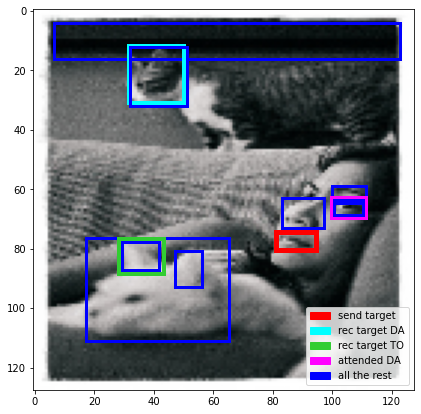

In [312]:
symbol1 = 3675 
symbol2 = 3665
guessed_DA = "no"
guessed_TO = "no"
att_head = 0

for check_batch in range(0,10):
    visual_analysis_2sym(symbol1, symbol2, check_batch, guessed_DA, guessed_TO, att_head) 

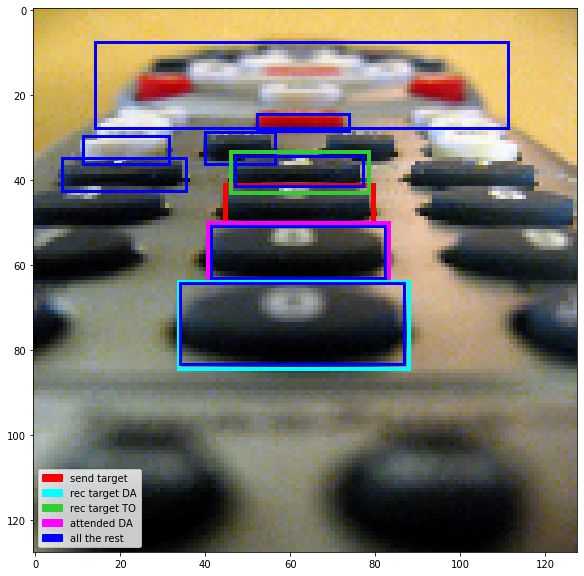

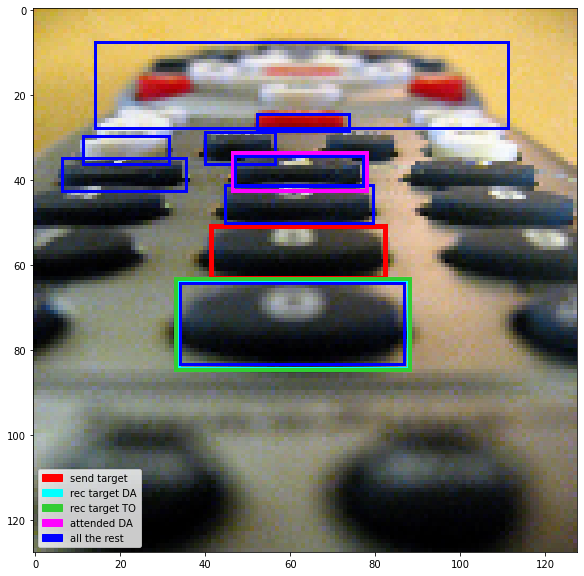

In [283]:
visual_analysis_2sym(2812, 3665, 3, "no", "no", 1) 

In [284]:
def visual_analysis_2sym(symbol1, symbol2, batch_id, guessed_DA, guessed_TO, num_att_head):

    for this_batch_id, batch in enumerate(msg_DA):
        if this_batch_id == batch_id:
            for idx_img, img, or_size, bboxes in list(zip(range(0,len(inter_DA.aux_input["sender_image"])),
                                            inter_DA.aux_input['sender_image'][this_batch_id],  
                                            inter_DA.aux_input["image_sizes"][this_batch_id],
                                            inter_DA.aux_input['bboxes'][this_batch_id])):
    
                or_w, or_h = or_size.tolist()[0][1], or_size.tolist()[0][2]
                xyxy = box_convert(bboxes, "xywh", "xyxy") 
                t_boxes = resize_boxes(xyxy, (or_w, or_h), (128,128))
                t_xywh = box_convert(t_boxes, "xyxy", "xywh") 
                image = img.permute(1, 2, 0)
                                 
                for idx_obj, mex, bbox, mask, guess_DA, obj, rcv_idx_DA, rcv_idx_TO, att_out_DA, in list(zip(range(0,len(inter_DA.aux_input["bboxes"])),
                                        msg_DA[this_batch_id][idx_img],
                                        inter_DA.aux_input['bboxes'][this_batch_id][idx_img],
                                        inter_DA.aux_input['mask'][this_batch_id][idx_img],
                                        inter_DA.aux_input['guesses'][this_batch_id][idx_img],
                                        t_xywh,
                                        rcv_out_DA[this_batch_id][idx_img],
                                        rcv_out_TO[this_batch_id][idx_img],
                                        inter_DA.aux_input["attn_weights"][this_batch_id][idx_img][num_att_head])): 
                    
                    if mask == True:
                        if guessed_DA == "yes": # IF DA HAS GUESSED
                            
                            if guessed_TO == "yes": # IF TO HAS GUESSED
                                
                                if mex[0] == symbol1 and mex[1] == symbol2 and guess_DA == 1.0 and rcv_idx_TO == idx_obj:
                                
                                    image_target_box(image, obj)
                    
                                    for idx_other_obj, other_obj in list(enumerate(t_xywh)):
                                    
                                        if idx_other_obj == rcv_idx_DA:
                                            assert other_obj.tolist() == obj.tolist(), "Mismatch guess!"
                                            aqua_box(other_obj)
                                        
                                        if idx_other_obj == rcv_idx_TO:
                                            assert other_obj.tolist() == obj.tolist(), "Mismatch guess!"
                                            green_box(other_obj)
                                        
                                        if idx_other_obj == torch.argmax(att_out_DA):
                                            fuchsia_box(other_obj)
                                   
                                        if idx_obj != idx_other_obj:
                                            blue_box(other_obj)
                                        
                            if guessed_TO == "no": # IF TO HAS NOT GUESSED
                                
                                if mex[0] == symbol1 and mex[1] == symbol2 and guess_DA == 1.0 and rcv_idx_TO != idx_obj:
                                
                                    image_target_box(image, obj)
                    
                                    for idx_other_obj, other_obj in list(enumerate(t_xywh)):
                                    
                                        if idx_other_obj == rcv_idx_DA:
                                            assert other_obj.tolist() == obj.tolist(), "Mismatch guess!"
                                            aqua_box(other_obj)
                                        
                                        if idx_other_obj == rcv_idx_TO:
                                            green_box(other_obj)
                                        
                                        if idx_other_obj == torch.argmax(att_out_DA):
                                            fuchsia_box(other_obj)
                                   
                                        if idx_obj != idx_other_obj:
                                            blue_box(other_obj)
                    
                    
                        elif guessed_DA == "no":
                            
                            if guessed_TO == "yes": # IF TO HAS GUESSED:
                                
                                if mex[0] == symbol1 and mex[1] == symbol2 and guess_DA != 1.0 and rcv_idx_TO == idx_obj:
                                
                                    image_target_box(image, obj)
                    
                                    for idx_other_obj, other_obj in list(enumerate(t_xywh)):       
                                    
                                        if idx_other_obj == rcv_idx_DA:
                                            aqua_box(other_obj)
                                        
                                        if idx_other_obj == rcv_idx_TO:
                                            assert other_obj.tolist() == obj.tolist(), "Mismatch guess!"
                                            green_box(other_obj)
                                        
                                        if idx_other_obj == torch.argmax(att_out_DA):
                                            fuchsia_box(other_obj)
                                        
                                        if idx_obj != idx_other_obj:
                                            blue_box(other_obj)
                                            
                            if guessed_TO == "no": # IF TO HAS NOT GUESSED:
                                
                                if mex[0] == symbol1 and mex[1] == symbol2 and guess_DA != 1.0 and rcv_idx_TO != idx_obj:
                                
                                    image_target_box(image, obj)
                    
                                    for idx_other_obj, other_obj in list(enumerate(t_xywh)):       
                                    
                                        if idx_other_obj == rcv_idx_DA:
                                            aqua_box(other_obj)
                                        
                                        if idx_other_obj == rcv_idx_TO:
                                            green_box(other_obj)
                                        
                                        if idx_other_obj == torch.argmax(att_out_DA):
                                            fuchsia_box(other_obj)
                                        
                                        if idx_obj != idx_other_obj:
                                            blue_box(other_obj)
                    
                        plt.show()

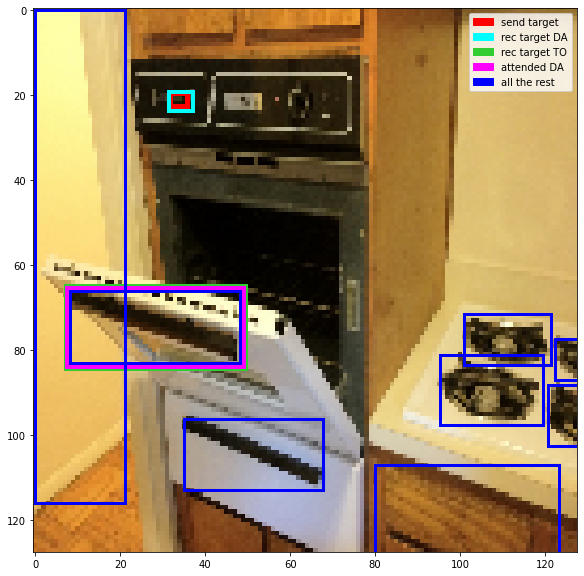

In [196]:
# here TO makes a mistake: it thinks that the target is the object that actually DA attends
# the same in batch 10
# NOT the same in batch 14
visual_analysis_2sym(2812, 3665, 9, "yes", "no", 0) 

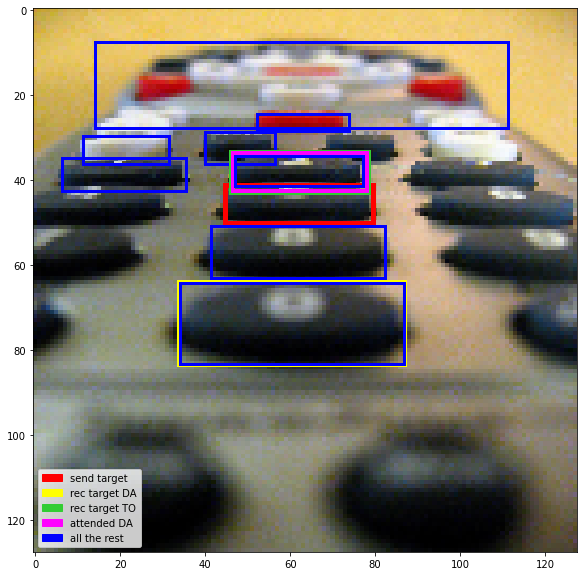

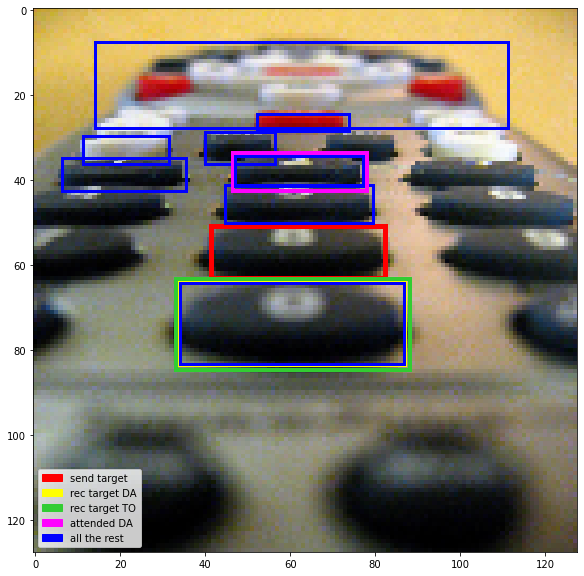

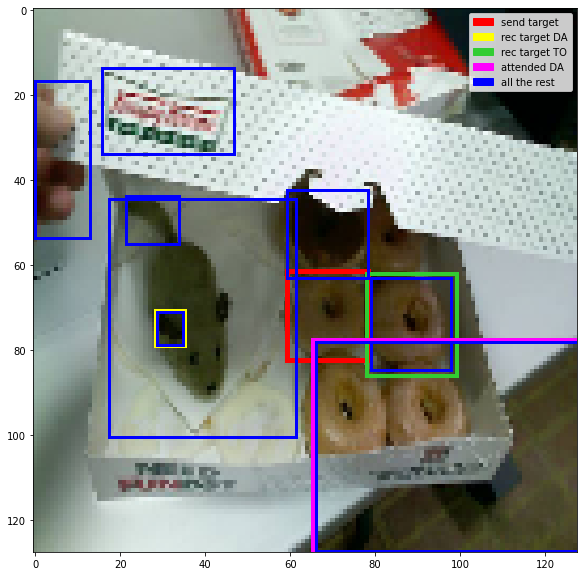

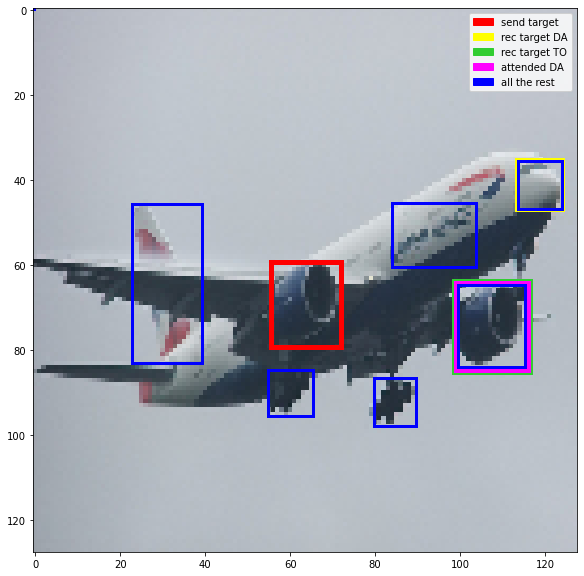

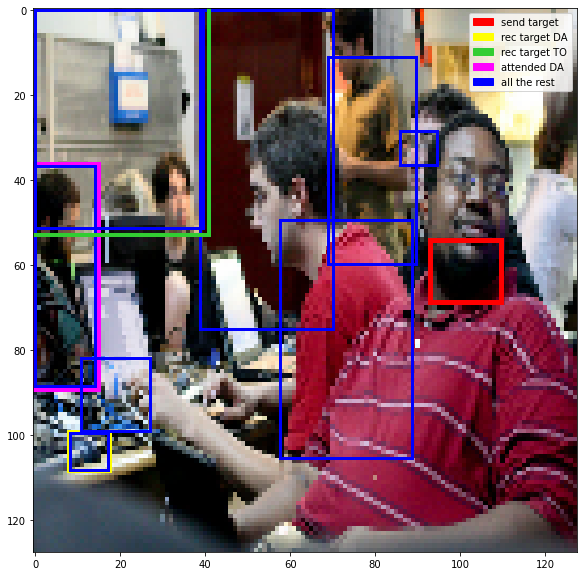

In [128]:
# cases where both models make it wrong are with multiple identical objects --> impossible
for check_batch in range(0,20):
    visual_analysis_2sym(2812, 3665, check_batch, "no", "no", 0) 

#### One symbol

In [243]:
def visual_analysis_1sym(symbol, pos, batch_id, guessed, num_att_head):

    for this_batch_id, batch in enumerate(msg):
        if this_batch_id == batch_id:
            for idx_img, img, or_size, bboxes in list(zip(range(0,len(inter.aux_input["sender_image"])),
                                            inter.aux_input['sender_image'][this_batch_id],  
                                            inter.aux_input["image_sizes"][this_batch_id],
                                            inter.aux_input['bboxes'][this_batch_id])):
    
                or_w, or_h = or_size.tolist()[0][1], or_size.tolist()[0][2]
                xyxy = box_convert(bboxes, "xywh", "xyxy") 
                t_boxes = resize_boxes(xyxy, (or_w, or_h), (128,128))
                t_xywh = box_convert(t_boxes, "xyxy", "xywh") 
                image = img.permute(1, 2, 0)
              
                for idx_obj, mex, bbox, mask, guess, obj, rcv_idx, att_out in list(zip(range(0,len(inter.aux_input["bboxes"])),
                                        msg[this_batch_id][idx_img],
                                        inter.aux_input['bboxes'][this_batch_id][idx_img],
                                        inter.aux_input['mask'][this_batch_id][idx_img],
                                        inter.aux_input['guesses'][this_batch_id][idx_img],
                                        t_xywh,
                                        rcv_out[this_batch_id][idx_img],
                                        inter.aux_input["attn_weights"][this_batch_id][idx_img][num_att_head])): 
                    
                    if mask == True:
                        if guessed == "yes":
                            if mex[pos] == symbol and guess == 1.0:
                                plt.figure(figsize=(13, 13))
                                
                                red_patch = mpatches.Patch(color='red', label='send target')
                                yellow_patch = mpatches.Patch(color='yellow', label='rec target')
                                white_patch = mpatches.Patch(color='white', label='attended')
                                blue_patch = mpatches.Patch(color='blue', label='all the rest')
                                plt.legend(handles=[red_patch, yellow_patch, white_patch, blue_patch], fontsize=10)
                                
                                plt.imshow(image)
                    
                                plt.gca().add_patch(Rectangle((obj[0], obj[1]),
                                                      obj[2], obj[3],
                                                      edgecolor='red', 
                                                      facecolor='none', lw = 4))
                    
                                for idx_other_obj, other_obj in list(enumerate(t_xywh)):
                                    if idx_obj != idx_other_obj:
                                        plt.gca().add_patch(Rectangle((other_obj[0], other_obj[1]),
                                                      other_obj[2], other_obj[3],
                                                      edgecolor='blue', 
                                                      facecolor='none', lw = 5))
                                    
                                    if idx_other_obj == rcv_idx:
                                        assert other_obj.tolist() == obj.tolist(), "Mismatch guess!"
                                        plt.gca().add_patch(Rectangle((other_obj[0]+0.3, other_obj[1]+0.3),
                                                      other_obj[2]+0.3, other_obj[3]+0.3,
                                                      edgecolor='yellow', 
                                                      facecolor='none', lw = 4))
                                        
                                    if idx_other_obj == torch.argmax(att_out):
                                        plt.gca().add_patch(Rectangle((other_obj[0]+0.3, other_obj[1]+0.3),
                                                      other_obj[2]+0.3, other_obj[3]+0.3,
                                                      edgecolor='white', 
                                                      facecolor='none', lw = 4))
                                    
                        elif guessed == "no":
                            if mex[pos] == symbol and guess != 1.0:
                                plt.figure(figsize=(13, 13))
                                
                                red_patch = mpatches.Patch(color='red', label='send target')
                                yellow_patch = mpatches.Patch(color='yellow', label='rec target')
                                white_patch = mpatches.Patch(color='white', label='attended')
                                blue_patch = mpatches.Patch(color='blue', label='all the rest')
                                plt.legend(handles=[red_patch, yellow_patch, white_patch, blue_patch], fontsize=10)
                                
                                plt.imshow(image)
                    
                                plt.gca().add_patch(Rectangle((obj[0], obj[1]),
                                                      obj[2], obj[3],
                                                      edgecolor='red', 
                                                      facecolor='none', lw = 4))
                    
                                for idx_other_obj, other_obj in list(enumerate(t_xywh)):
                                    if idx_obj != idx_other_obj:
                                        plt.gca().add_patch(Rectangle((other_obj[0], other_obj[1]),
                                                      other_obj[2], other_obj[3],
                                                      edgecolor='blue', 
                                                      facecolor='none', lw = 5))
                                    if idx_other_obj == rcv_idx:
                                        plt.gca().add_patch(Rectangle((other_obj[0]+0.3, other_obj[1]+0.3),
                                                      other_obj[2]+0.3, other_obj[3]+0.3,
                                                      edgecolor='yellow', 
                                                      facecolor='none', lw = 4))
                                        
                                    if idx_other_obj == torch.argmax(att_out):
                                        plt.gca().add_patch(Rectangle((other_obj[0]+0.3, other_obj[1]+0.3),
                                                      other_obj[2]+0.3, other_obj[3]+0.3,
                                                      edgecolor='white', 
                                                      facecolor='none', lw = 4))
                    
                        plt.show()

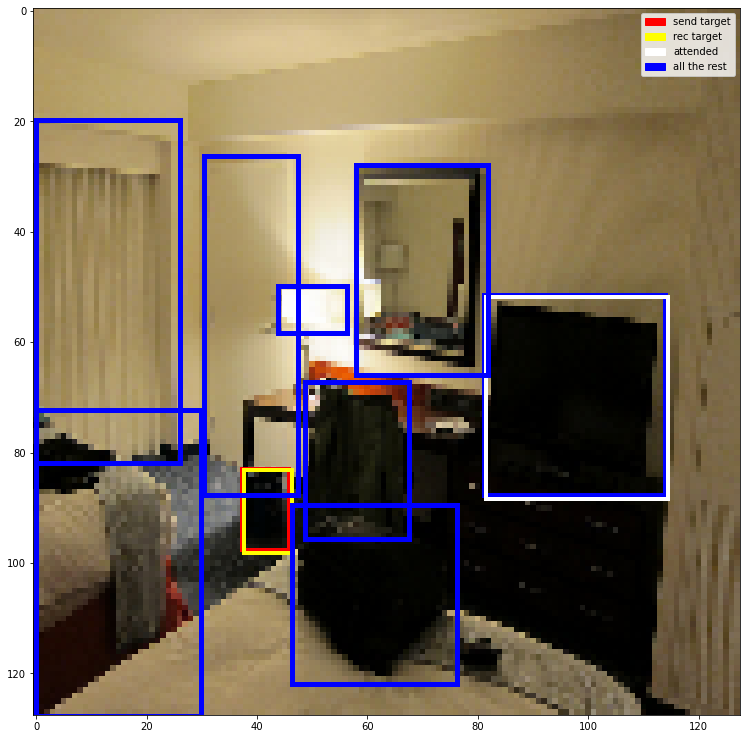

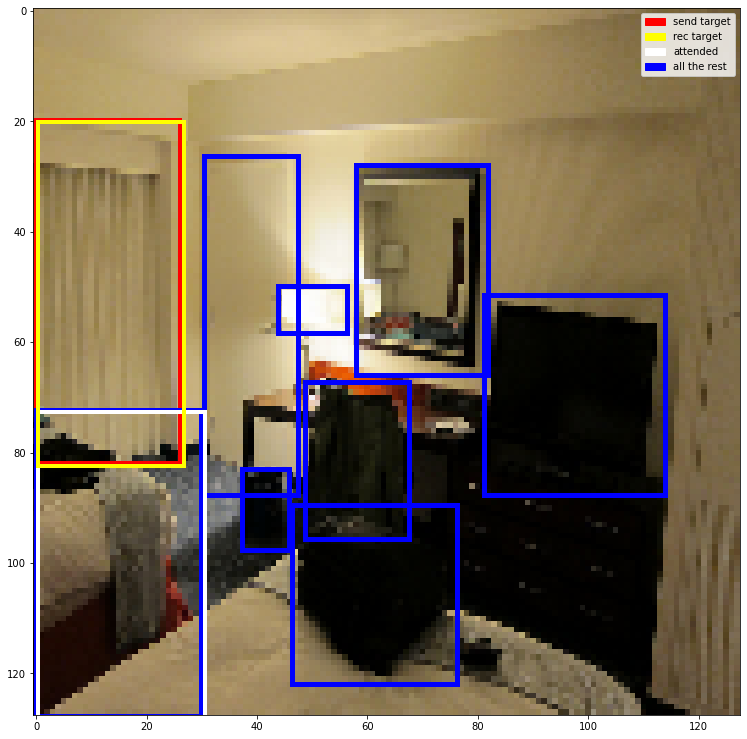

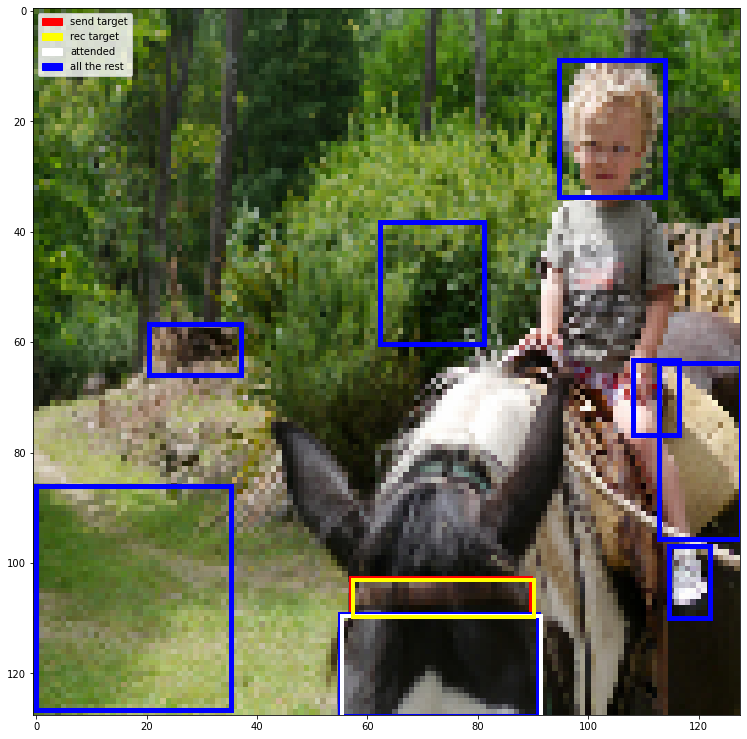

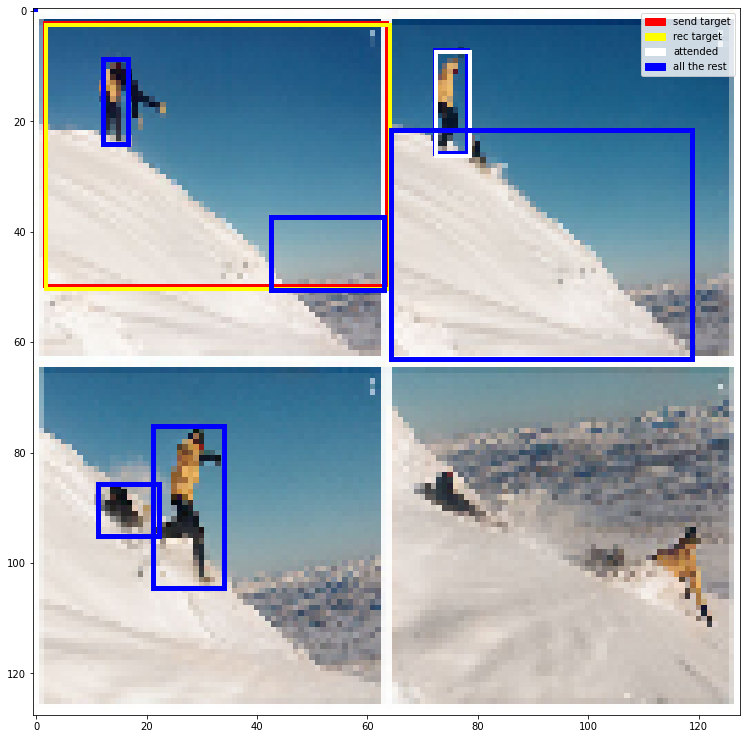

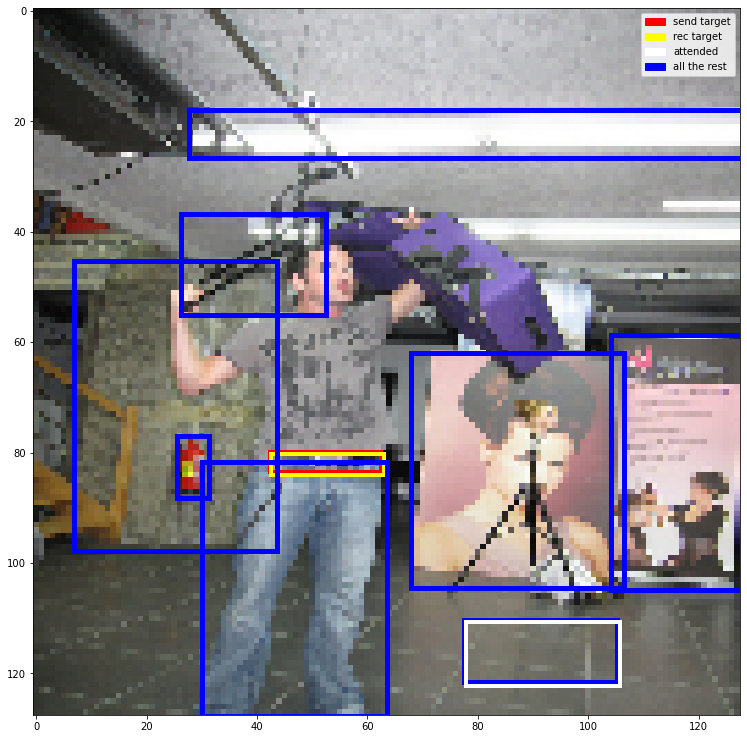

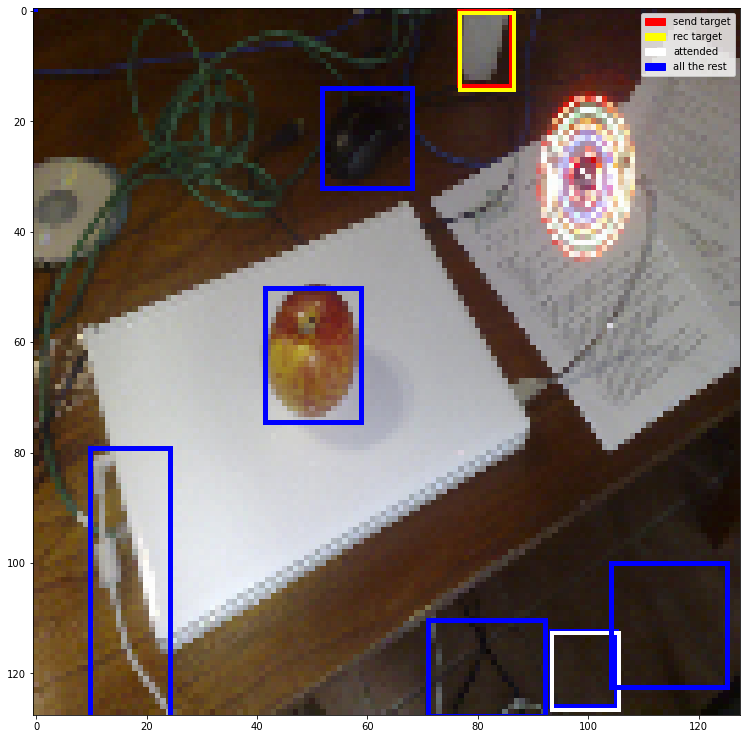

KeyboardInterrupt: 

In [244]:
visual_analysis_1sym(1552, 0, 0, "yes", 0)